<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/MRIcnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN Model**


**Importing Libraries**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
tf.__version__

'2.5.0'

**Data Preprocessing**

In [20]:
image_size = (64, 64)
batch_size = 32

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/mri_images/test",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/mri_images/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 569 files belonging to 3 classes.
Using 456 files for training.
Found 569 files belonging to 3 classes.
Using 113 files for validation.


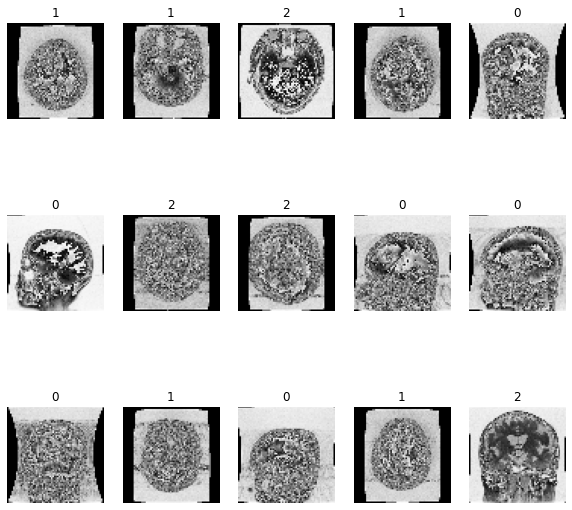

In [10]:
#visualize data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [11]:
#using data augumentaion
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

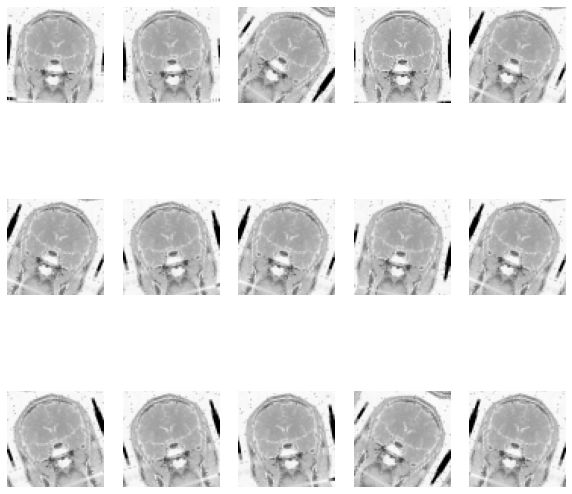

In [12]:
#visualise the augumented data
plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
augmented_train_set = train_set.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [14]:
#make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking
train_set = train_set.prefetch(buffer_size=32)
val_set = val_set.prefetch(buffer_size=32)

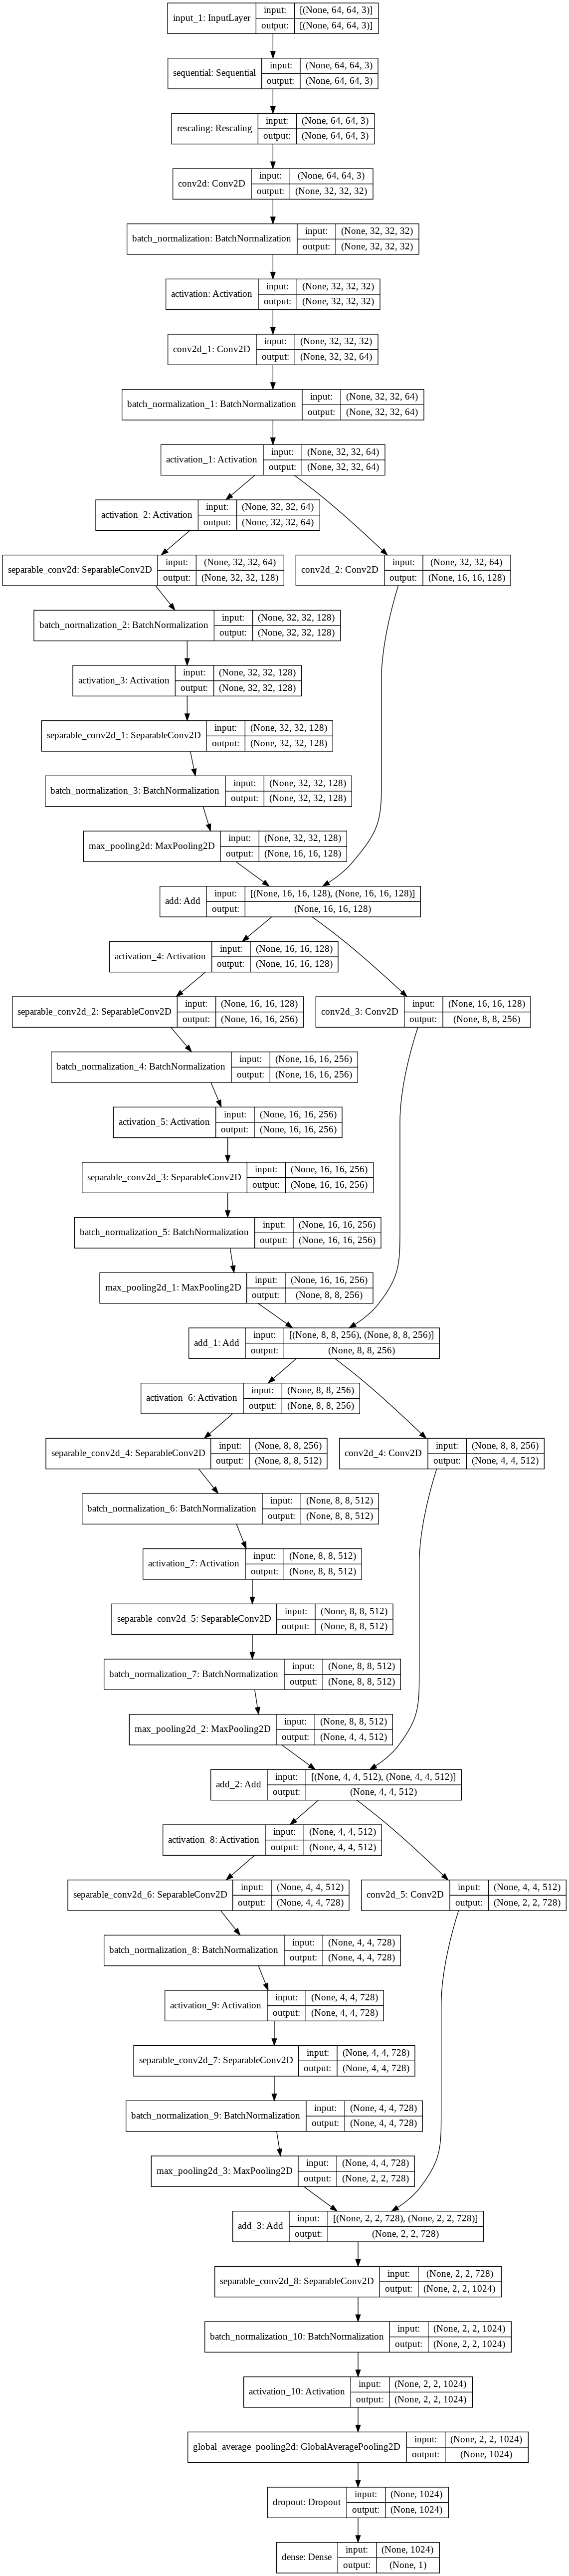

In [15]:
#Build the CNN model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization(axis=-1)(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization(axis=-1)(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [16]:
#Train the model
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_set, epochs=epochs, callbacks=callbacks, validation_data=val_set,
)

Epoch 1/50
15/15 [==============================] - 61s 4s/step - loss: -2.9161 - accuracy: 0.4364 - val_loss: 0.6692 - val_accuracy: 0.4867
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


15/15 [==============================] - 17s 1s/step - loss: -9.5017 - accuracy: 0.4715 - val_loss: 0.6779 - val_accuracy: 0.4956
Epoch 3/50
15/15 [==============================] - 17s 1s/step - loss: -14.4574 - accuracy: 0.5110 - val_loss: 0.5940 - val_accuracy: 0.2124
Epoch 4/50
15/15 [==============================] - 17s 996ms/step - loss: -19.5301 - accuracy: 0.5110 - val_loss: 0.3004 - val_accuracy: 0.2124
Epoch 5/50
15/15 [==============================] - 17s 999ms/step - loss: -25.3249 - accuracy: 0.5219 - val_loss: 0.2590 - val_accuracy: 0.2124
Epoch 6/50
15/15 [==============================] - 17s 1000ms/step - loss: -31.9272 - accuracy: 0.5395 - val_loss: 0.0481 - val_accuracy: 0.2124
Epoch 7/50
15/15 [==============================] - 17s 1s/step - loss: -37.9533 - accuracy: 0.5219 - val_loss: 0.1315 - val_accuracy: 0.2124
Epoch 8/50
15/15 [==============================] - 17s 996ms/step - loss: -44.3033 - accuracy: 0.5241 - val_loss: 0.4196 - val_accuracy: 0.2124
Epoch

In [23]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('drive/MyDrive/mri_images/test/1/1.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#train_set.class_indices
prediction = ''
if result[0][0] ==0:
        prediction = 'glioma'
elif result[0][0] ==1:
       prediction = 'meningioma'
elif result[0][0] ==2:
      prediction = 'pituitary'
else:
       prediction = 'Not Tumor'



In [24]:
  print(prediction)

meningioma


In [27]:
img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_set.class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 0 with a 100.00 percent confidence.
